<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list -s "ovarian cancer"

ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2860         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3475         48  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1533         38  1.0          

In [5]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Define dataset path
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}
IMG_SIZE = 224

X, y = [], []
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_path):
        continue
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Load EfficientNetB0
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[-5:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train, y_train, batch_size=16)

In [10]:
# Train Model
history = model.fit(train_generator, validation_data=(X_test, y_test), epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.3543 - loss: 2.5545 - val_accuracy: 0.5100 - val_loss: 1.3152
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.6633 - loss: 1.0779 - val_accuracy: 0.6100 - val_loss: 1.2222
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.7305 - loss: 1.0349 - val_accuracy: 0.6200 - val_loss: 1.4143
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.8089 - loss: 0.7748 - val_accuracy: 0.7100 - val_loss: 1.0950
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.7872 - loss: 0.5882 - val_accuracy: 0.6500 - val_loss: 1.3423
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.8689 - loss: 0.5573 - val_accuracy: 0.7200 - val_loss: 1.1315
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.8162 - loss: 0.6148 - val_accuracy: 0.8400 - val_loss: 0.4927
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.8746 - loss: 0.4059 - val_accuracy: 0.8000 - v

In [11]:
# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Loss: {loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8455 - loss: 0.9488
Test Accuracy: 0.83
Test Loss: 0.8906


In [12]:
# Save Model
model.save("efficientnetb0_ovarian_cancer_model.h5")
print("Model saved successfully!")


Model saved successfully!


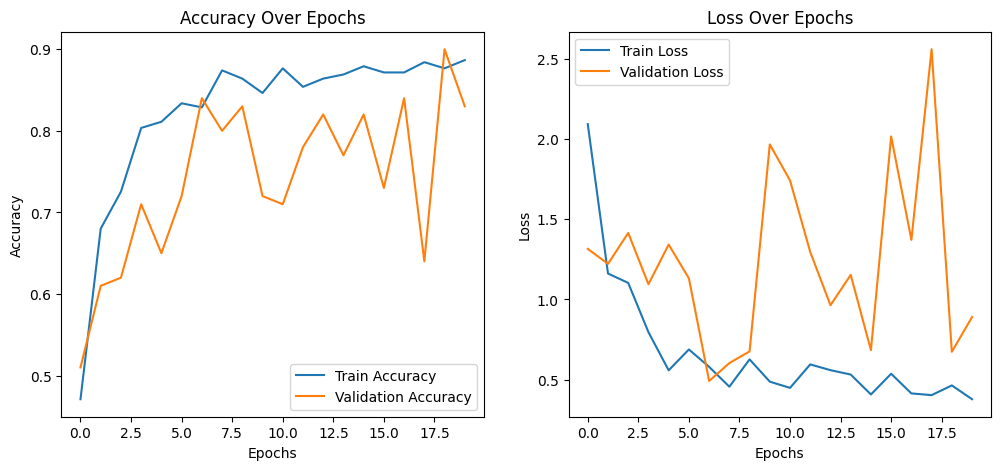

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
